In [16]:
import gym
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os
env = gym.make('gym_robot_arm:robot-arm-v0')
obs = env.reset()
obs

array([-57.32319667, 159.50103817,   0.78216102,   0.8514433 ])

In [17]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=np.object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

In [18]:
class QNetwork(tf.Module):
    def __init__(self, lr=1e-3, input_shape = [4], n_outputs = 7):
        super(QNetwork, self).__init__()
        self.optimizer = keras.optimizers.Adam(lr=lr)
        self.loss = keras.losses.mean_squared_error
        self.model = self.get_model()

    def get_model(self):
        input_shape = [4]
        n_outputs =  7
        K = keras.backend
        input_states = keras.layers.Input(shape=[4])
        hidden1 = keras.layers.Dense(64, activation="relu")(input_states)
        hidden2 = keras.layers.Dense(64, activation="relu")(hidden1)
        hidden3 = keras.layers.Dense(64, activation="relu")(hidden2)
        state_values = keras.layers.Dense(1)(hidden3)
        raw_advantages = keras.layers.Dense(n_outputs)(hidden3)
        advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
        Q_values = state_values + advantages
        model = keras.models.Model(inputs=[input_states], outputs=[Q_values])
        return model

In [19]:
class DQNAgent(object):
    def __init__(self):
        self.epsilon = 1
        self.replay_memory = ReplayMemory(max_size=1000000)
        self.batch_size = 32
        self.discount_rate = 0.95
        self.network = QNetwork()
        self.model = self.network.model
        self.target = keras.models.clone_model(self.model)
        self.target.set_weights(self.model.get_weights())
        self.n_outputs = 7
        self.input_shape = [4]
        self.optimizer = self.network.optimizer
        self.loss_fn = self.network.loss

    def epsilon_greedy_policy(self, state, epsilon=0):
        if np.random.rand() < epsilon:
            return np.random.randint(2)
        else:
            Q_values = self.model.predict(state[np.newaxis])
            return np.argmax(Q_values[0])

    def sample_experiences(self, batch_size):
        indices = self.replay_memory.sample(batch_size)
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in indices])
            for field_index in range(5)]
        return states, actions, rewards, next_states, dones  

    def play_one_step(self, env, state, epsilon):
        action = self.epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, info = env.step(action)
        self.replay_memory.append((state, action, reward, next_state, done))
        return next_state, reward, done, info
    
    def training_step(self, batch_size):
        experiences = self.sample_experiences(batch_size)
        states, actions, rewards, next_states, dones = experiences
        next_Q_values = self.model.predict(next_states)
        best_next_actions = np.argmax(next_Q_values, axis=1)
        next_mask = tf.one_hot(best_next_actions, self.n_outputs).numpy()
        next_best_Q_values = (self.target.predict(next_states) * next_mask).sum(axis=1)
        target_Q_values = (rewards + 
                        (1 - dones) * self.discount_rate * next_best_Q_values)
        target_Q_values = target_Q_values.reshape(-1, 1)
        mask = tf.one_hot(actions, n_outputs)
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))


In [20]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
input_shape = [4]
n_outputs =  7
rewards = []
best_score = 0

agent = DQNAgent()


In [21]:


for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        agent.epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = agent.play_one_step(env, obs, agent.epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = agent.model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, agent.epsilon), end="")
    if episode > 50:
        agent.training_step(agent.batch_size)
    if episode % 200 == 0:
        agent.target.set_weights(agent.model.get_weights())

agent.model.set_weights(best_weights)

Episode: 599, Steps: 12, eps: 0.010

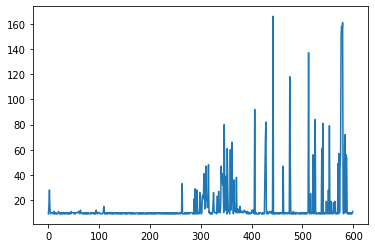

In [23]:
import matplotlib.pyplot as plt
plt.plot(rewards)